In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = "/content/drive/MyDrive/Colab_Notebook/GAN_Agriculture"
os.chdir(Root)

In [ ]:
!nvidia-smi

Sun Sep 12 02:45:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path_celeb = []
train_path_celeb = "/content/drive/MyDrive/Colab_Notebook/GAN_Agriculture/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))
    elif '.jpeg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))
    else:
      print("Something is wrong")

In [ ]:
len(new_path)

50000

In [ ]:
images = [np.array((Image.open(path).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer
    
images = np.array(images) 

In [ ]:
train_data=images

In [ ]:
len(path_celeb)

202599

In [ ]:
print(train_data.shape)

(50000, 64, 64, 3)


<Figure size 720x720 with 0 Axes>

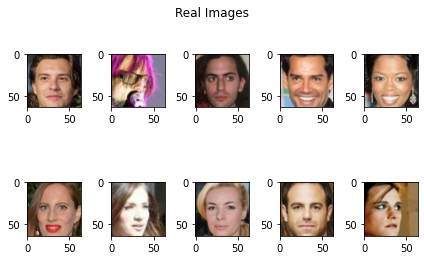

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=600
            
plt.tight_layout()
plt.show()

In [ ]:
X_train = train_data

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-z_w4gezj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-z_w4gezj
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.08c628cf4c26ea0e700e6ca651c62f4cafe4faa83_-py3-none-any.whl size=157210 sha256=462cecfe9051de913a70d03a1d4e857d73ea11d8c86f546451ca2ed146497ad8
  Stored in directory: /tmp/pip-ephem-wheel-cache-fa5i5d68/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape

In [ ]:
noise_shape = 100

In [ ]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

In [ ]:
generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 8192)              827392    
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16, 16, 128)     

In [ ]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 8, 128)       

In [ ]:
GAN =Sequential([generator,discriminator])

In [ ]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [ ]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 64, 64, 3)         3585219   
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 695009    
Total params: 4,280,228
Trainable params: 3,584,323
Non-trainable params: 695,905
_________________________________________________________________


In [ ]:
epochs = 300  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 128

In [ ]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

Currently on Epoch 1
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390


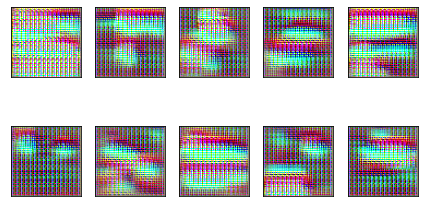

Epoch: 1,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.194
Currently on Epoch 2
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 2,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.006
Currently on Epoch 3
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 3,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.007
Currently on Epoch 4
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 4,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epoch 5
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 5,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epo

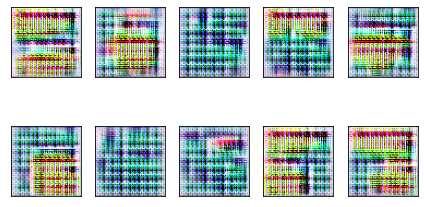

Epoch: 6,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epoch 7
	Currently on batch number 0 of 390


KeyboardInterrupt: ignored

In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

**For Inference**

In [ ]:
noise=np.random.uniform(-1,1,size=[500,noise_shape])

In [ ]:
im=generator.predict(noise)

In [ ]:
for i in range(5):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

In [ ]:
import pickle
Pkl_Filename = "DCGAN.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(GAN, file)